# Let's make this computer sound like a guitar!

Years and years ago, I read on some internet forum how to synthesize a guitar-like sound on a computer. I don't know much about audio synthesis, and I don't remember where I originally got this trick, but I looked up my old code and really it's kind of neat.

And surprisingly random.

In [1]:
import numpy as np
import scipy.signal
from IPython.display import Audio

In [2]:
# 44.1 kHz is the PCM sampling rate of CD audio
srate = 44_100 # samples / second

I generate a block of white noise with a width equivalent to twice<sup>†</sup> the period of the frequency I want,

```py3
rnd_block = np.random.randint(-2**15, 2**15-1, size=τ_samples, dtype='i2')
```

within the entire valid range of a 16-bit signed integer (which we're using for our audio data. It's the most common format…)

And then we just kind of mush them together. That already gives us a signal at the right pitch. To get a sound that decays in a natural way, though, we can simply successively smooth each of our random blocks by convolving them with some kind of kernel

```py3
wnd = np.array([1, 2, 3, 2, 1]) / 9 # this window is fairly arbitrary
buf[:] = scipy.signal.fftconvolve(buf, wnd, mode='same')
```

such that the random signal gets smoother and smoother and weaker and weaker over time

---

<sup>†</sup> can't quite explain the factor 2 at the moment

In [3]:
def pluck(trak, f, start_sec, vol_factor=.5):
    τ_samples = int(2 * srate / f)
    # It's just random numbers
    rnd_block = np.random.randint(-2**15, 2**15-1, size=τ_samples, dtype='i2')
    rnd_block -= np.mean(rnd_block, dtype='i2')
    
    bleed = 2
    buf = np.zeros(τ_samples + 2 * bleed, dtype='i2')
    buf[bleed:bleed+τ_samples] = rnd_block
    for i0 in np.arange(int(start_sec * srate), len(trak) - τ_samples, τ_samples):
        trak[i0:i0+τ_samples] += np.asarray(buf[bleed:-bleed] * vol_factor, dtype='i2')
        buf[:bleed], buf[-bleed:] = buf[-2*bleed:-bleed], buf[bleed:2*bleed]
        wnd = np.array([1, 2, 3, 2, 1]) / 9 # this window is fairly arbitrary
        buf[:] = scipy.signal.fftconvolve(buf, wnd, mode='same')


In [4]:
# equal temperament
semitone_factor = 2 ** (1 / 12.0)

trak = np.zeros(3 * srate, dtype='i2') # 3 seconds
pluck(trak, 440 * semitone_factor**(-17), .2, .1) # E
pluck(trak, 440 * semitone_factor**(-12), .4, .1) # A
pluck(trak, 440 * semitone_factor**(-7), .6, .1) # D
pluck(trak, 440 * semitone_factor**(-2), .8, .1) # G
pluck(trak, 440 * semitone_factor**(+2), 1.0, .1) # B
pluck(trak, 440 * semitone_factor**(+7), 1.2, .1) # E

Audio(data=trak, rate=srate)

... and this sounds like a guitar

Let's have a look at the waveform and Fourier transform of the result for a single note, e.g. the 220 Hz A

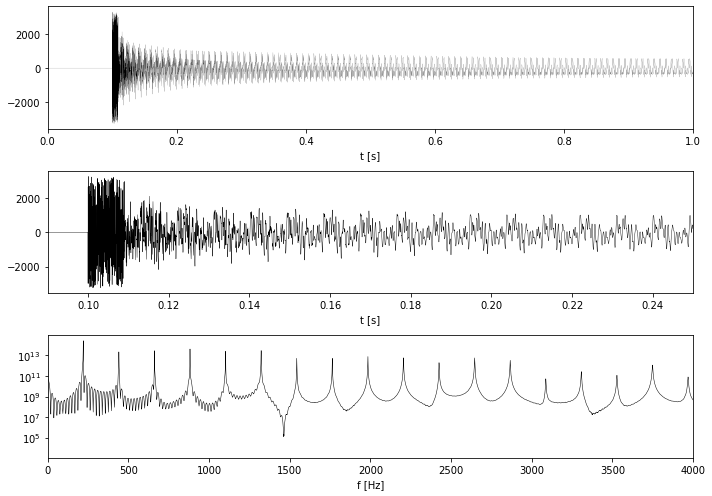

In [5]:
from matplotlib import pyplot as plt

trak = np.zeros(3 * srate, dtype='i2') # 3 seconds
pluck(trak, 440 * semitone_factor**(-12), .1, .1) # A

fig, axs = plt.subplots(3, 1, figsize=(10, 7))
dt = 1 / srate
t = np.arange(0, len(trak)) * dt
axs[0].plot(t, trak, lw=.1, color='k')
axs[0].set_xlabel('t [s]')
axs[0].set_xlim(0, 1)

axs[1].plot(t, trak, lw=.4, color='k')
axs[1].set_xlabel('t [s]')
axs[1].set_xlim(0.09, .25)

F = np.fft.rfft(trak)
F_freq = np.fft.fftfreq(len(F), dt)
axs[2].semilogy(F_freq[:len(F)//2], np.abs(F[:len(F)//2])**2, lw=.5, color='k')
axs[2].set_xlim(0, 4000)
axs[2].set_xlabel('f [Hz]')

fig.tight_layout()

You can clearly see the repeating waveform with the right frequency emerging from the random noise – and it's also pretty clear that the dominant frequencies are (ALL) the harmonics.

So that's cool.